#### Notes
- DATASET: Customer-level data of a leading telecom firm, 
    - Data spans over four consecutive months - June, July, August and September. 
    - First 2 months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
- GOAL: Identify customers at high risk of churn and identify the main indicators of churn.
- Business objective: Predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this project 
- it is primarliy Indian and Southeast Asian market.
- the usage-based definition is used to define churn.
- High-value customers are deinfed - who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase) = 29.9k rows
- Predict churn only on high-value customers.

### Strategy followed for analysis & model building
- Data understanding and exploration
- Data pre-processing
    - Filter high-value customers
    - Tag churners and remove attributes of the churn phase
    - Derive new features
    - Impute Missing value
    - Handle Outliers
    - Create Dummy variables 
- Data Preparation
    - Test train split
    - Standardise numerical values
- Dimensionality reduction (PCA)
- Predict customers who will churn - Train a variety of models and evaluate
    - Build model and evaluate
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Identify important predictor attributes to understand indicators of churn - Logistic regression or a model from the tree family
    - Build model and evaluate 
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Recommend strategies to manage customer churn

#### Hints
- Using techniques to handle class imbalance - stratify
- In case of logistic regression, make sure to handle multi-collinearity.

### Imports & Functions

In [240]:
import sys

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [241]:
# Calculates and returns the percentage of a value in the total
def percent(value, total):
    return round(100 * value/total, 2)  

def listColumns(df):
    print(f"{len(df.columns.tolist())} {df.columns.tolist()}")

def getColumnsWithPrefix(prefix, cols):
    lenPrefix = len(prefix)
    l =list(filter(lambda x: True if x[:lenPrefix]==prefix else False,cols))
    print(len(l), l)
    return l

# Lists the columns with missing values - col name, absolute number and percentage of cells missing in the column. 
# The columns are sorted in descending order of the number of missing values.
def listColumsWithMissingData(df, LIMIT=0):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    cols = {}
    for col in df.columns:
        if df[col].isna().any():
            missing_count = df[col].isna().sum(),percent(df[col].isna().sum(),df.shape[0])
            #print(col, missing_count)
            if missing_count[1] < LIMIT: continue
            cols[col] = missing_count
    cols = sorted(cols.items(), key=lambda x: x[1][0], reverse=True)
    #[print(f"{col[0]:15}  {col[1][0]:7d} {col[1][1]}%") for col in cols ]
    return cols

# Displays the columns with missing data using msno matrix and bar
def displayColumnsWithMissingData(df_):
    plt.figure(figsize=(10, 6 ))
    msno.matrix(df_[df_.columns[df_.isnull().any()]]);plt.show()
    msno.bar(df_[df_.columns[df_.isnull().any()]]);plt.show()

# Gets the list of columns which are categorical in nature
def getCategoricalColumns(df):
    cat_columns_ = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns = sorted(cat_columns_)
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    return cat_columns_

# For each categorical column, 
# - prints all the unique values 
# - plots the distribution of values
def plotCategoricalVariables(df_, cat_columns, title):
    COLS = 4
    count = len(cat_columns)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = cat_columns[i]
        count_values = df_[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df_[col].unique().tolist())) if np.NaN not in df_[col].unique().tolist() else (df_[col].unique().tolist())}")
        df__ = df_[[col]].value_counts(normalize=True)*100
        plt.subplot(rows, COLS, i+1);ax=df__.plot.bar();_ = plt.xticks(rotation=0); annotate(ax)
    fig.suptitle(title, fontsize=14)

# Gets the list of columns which are numerical in nature
def getNumericalColumns(df):
    num_columns_ = df.select_dtypes(include=[np.float, np.int64]).columns.tolist()
    num_columns_ = sorted(num_columns_)
    print(f"Columns with numerical values {len(num_columns_)} --> {num_columns_}")
    return num_columns_ 

# For each numerical column, 
# - prints all the unique values (if <30), else prints 10 values
# - plots the distribution of values - distplot (for columns with >30 unique values) or histplot (for columns with <30 unique values)
def plotNumericalVariables(df_, num_cols, title):
    COLS = 4
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        count_values = df_[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.distplot(df_[col])
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 
            #ax=df[col].plot.hist(weights=np.ones(df.shape[0]) / df.shape[0]);annotate(ax, title=col);plt.show()
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.histplot(data=df_[col])

    fig.suptitle(title, fontsize=14)

# Converts the category to a ordinal numerical label
def clategoryToOridnalLabel(X, cat):
    oe = preprocessing.OrdinalEncoder(categories=cat)
    oe.fit(X)
    print(oe.categories_)
    X1 = oe.transform(X)
    #print(X1[:5])
    return X1
    #print(oe.feature_names_in_)

# Creates dummies for categorical columns and returns the combined dataframe
# The categorical column should be dropped.
def addDummies(df, col, dropcat, df_out):
    print(f"[{col}] Before: {df_out.columns.shape[0]}", end=' ')
    temp = pd.get_dummies(df[col], prefix=col, drop_first=True)
    #df.drop(columns=[col], inplace=True)
    #temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print(f"After: {df_out.columns.shape[0]}", end=' ')
    print()
    return df_out

# Annotates the bars
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

# Read the dataset

In [242]:
df = pd.read_csv("telecom_churn_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [243]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


<Figure size 720x432 with 0 Axes>

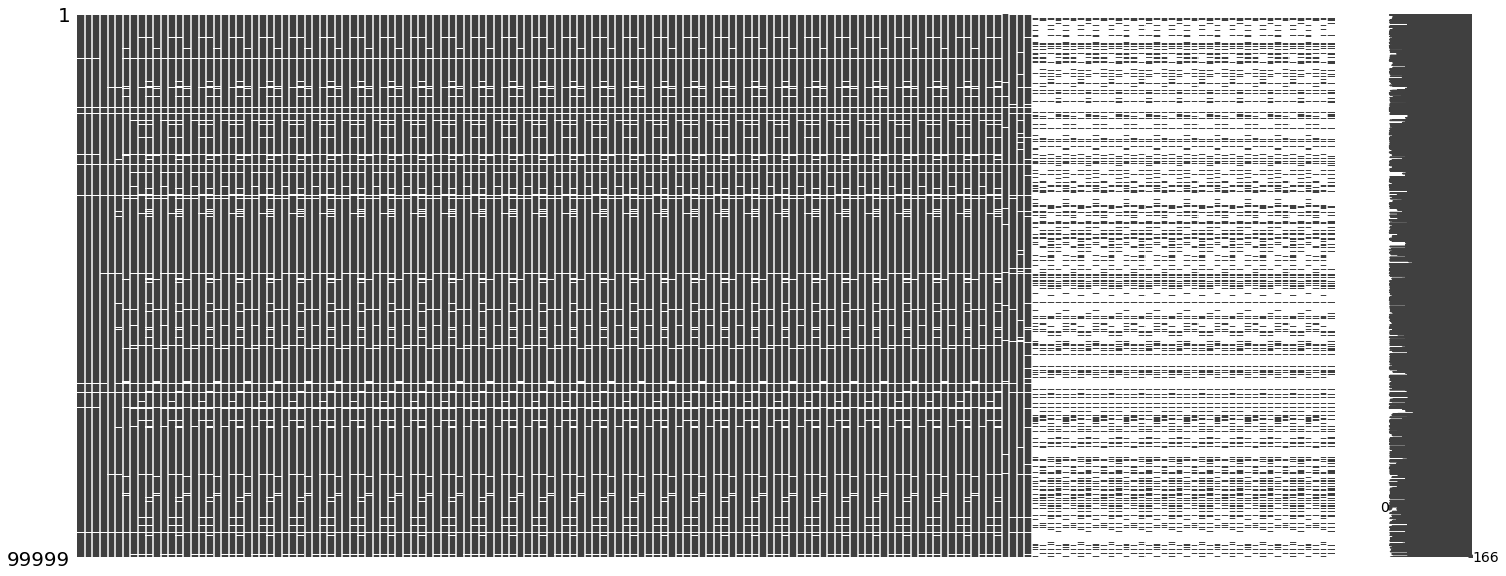

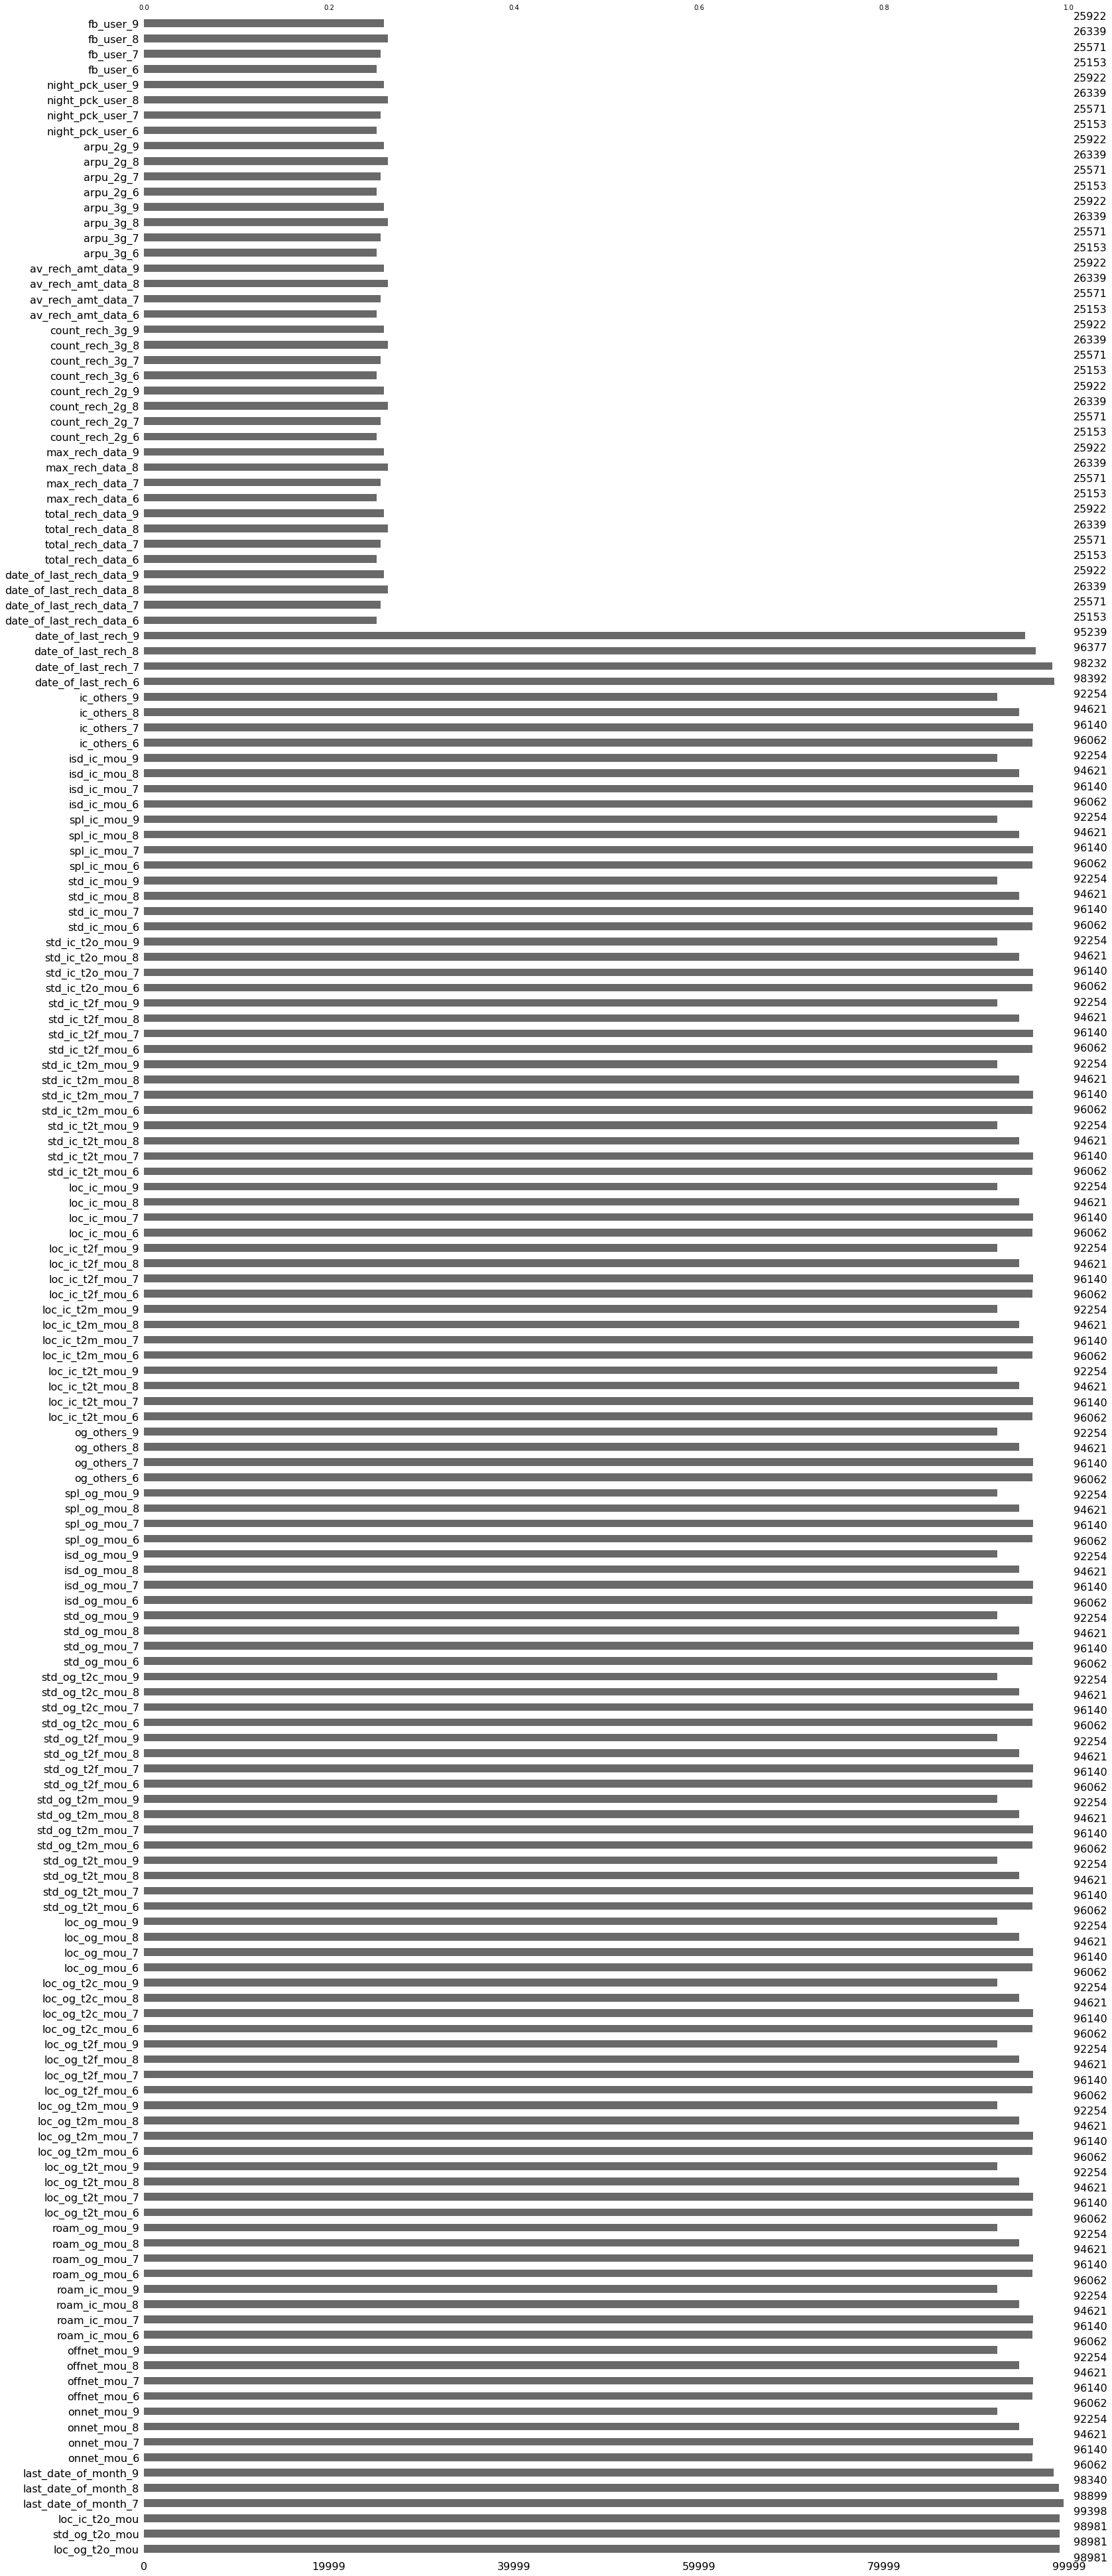

Columns with missing data: 166 73.45%


[('date_of_last_rech_data_6', (74846, 74.85)),
 ('total_rech_data_6', (74846, 74.85)),
 ('max_rech_data_6', (74846, 74.85)),
 ('count_rech_2g_6', (74846, 74.85)),
 ('count_rech_3g_6', (74846, 74.85)),
 ('av_rech_amt_data_6', (74846, 74.85)),
 ('arpu_3g_6', (74846, 74.85)),
 ('arpu_2g_6', (74846, 74.85)),
 ('night_pck_user_6', (74846, 74.85)),
 ('fb_user_6', (74846, 74.85)),
 ('date_of_last_rech_data_7', (74428, 74.43)),
 ('total_rech_data_7', (74428, 74.43)),
 ('max_rech_data_7', (74428, 74.43)),
 ('count_rech_2g_7', (74428, 74.43)),
 ('count_rech_3g_7', (74428, 74.43)),
 ('av_rech_amt_data_7', (74428, 74.43)),
 ('arpu_3g_7', (74428, 74.43)),
 ('arpu_2g_7', (74428, 74.43)),
 ('night_pck_user_7', (74428, 74.43)),
 ('fb_user_7', (74428, 74.43)),
 ('date_of_last_rech_data_9', (74077, 74.08)),
 ('total_rech_data_9', (74077, 74.08)),
 ('max_rech_data_9', (74077, 74.08)),
 ('count_rech_2g_9', (74077, 74.08)),
 ('count_rech_3g_9', (74077, 74.08)),
 ('av_rech_amt_data_9', (74077, 74.08)),
 ('a

In [244]:
displayColumnsWithMissingData(df)
listColumsWithMissingData(df)

In [245]:
print("Duplicates in mobiler:", df[df['mobile_number'].duplicated()]['mobile_number'].shape[0])
print("Duplicates in circle_id", df[df['circle_id'].duplicated()]['circle_id'].shape[0])

Duplicates in mobiler: 0
Duplicates in circle_id 99998


As all the rows have the same value, we can drop circle_id.

In [246]:
COLS_MISS = listColumsWithMissingData(df, 40); [print(col[0], end=', ') for col in COLS_MISS]; print()

Columns with missing data: 166 73.45%
date_of_last_rech_data_6, total_rech_data_6, max_rech_data_6, count_rech_2g_6, count_rech_3g_6, av_rech_amt_data_6, arpu_3g_6, arpu_2g_6, night_pck_user_6, fb_user_6, date_of_last_rech_data_7, total_rech_data_7, max_rech_data_7, count_rech_2g_7, count_rech_3g_7, av_rech_amt_data_7, arpu_3g_7, arpu_2g_7, night_pck_user_7, fb_user_7, date_of_last_rech_data_9, total_rech_data_9, max_rech_data_9, count_rech_2g_9, count_rech_3g_9, av_rech_amt_data_9, arpu_3g_9, arpu_2g_9, night_pck_user_9, fb_user_9, date_of_last_rech_data_8, total_rech_data_8, max_rech_data_8, count_rech_2g_8, count_rech_3g_8, av_rech_amt_data_8, arpu_3g_8, arpu_2g_8, night_pck_user_8, fb_user_8, 


Do we need to handle missing values for 
- PCA?
- decision trees/random forest? 

In [247]:
listColumns(df)

226 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m

In [248]:
COLS= df.columns.tolist()
COLS_ID = ['mobile_number']
COLS_LOC = getColumnsWithPrefix('loc',COLS) # LOCAL
COLS_STD = getColumnsWithPrefix('std',COLS)
COLS_ISD = getColumnsWithPrefix('isd',COLS)
COLS_LAST_DATE = getColumnsWithPrefix('last_date_',COLS)
COLS_DATE = getColumnsWithPrefix('date_',COLS)
COLS_ARPU = getColumnsWithPrefix('arpu',COLS)
COLS_ONNET = getColumnsWithPrefix('onnet',COLS)
COLS_OFFNET = getColumnsWithPrefix('offnet',COLS)
COLS_ROAM = getColumnsWithPrefix('roam',COLS)
COLS_SPL = getColumnsWithPrefix('spl',COLS)
COLS_OG = getColumnsWithPrefix('og',COLS)
COLS_IC = getColumnsWithPrefix('ic',COLS)
COLS_TOTAL = getColumnsWithPrefix('total',COLS)
COLS_MAX = getColumnsWithPrefix('max',COLS)
COLS_COUNT = getColumnsWithPrefix('count',COLS)
COLS_AV = getColumnsWithPrefix('av',COLS)
COLS_VOL = getColumnsWithPrefix('vol',COLS)
COLS_NIGHT = getColumnsWithPrefix('night',COLS)
COLS_MONTH = getColumnsWithPrefix('monthly',COLS)
COLS_SACHET = getColumnsWithPrefix('sachet',COLS)
COLS_FB = getColumnsWithPrefix('fb_user',COLS)
COLS_4_MON = getColumnsWithPrefix('jun',COLS) + getColumnsWithPrefix('jul',COLS) + getColumnsWithPrefix('aug',COLS) + getColumnsWithPrefix('sep',COLS)

38 ['loc_og_t2o_mou', 'loc_ic_t2o_mou', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
41 ['std_og_t2o_mou', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_t2

In [249]:
df[COLS_LAST_DATE].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014


In [250]:
df[COLS_DATE].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [251]:
COLS_CAT = getCategoricalColumns(df)

Columns with categorical values 12 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']


In [252]:
df[COLS_CAT].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [253]:
COLS_NUM = getNumericalColumns(df)

Columns with numerical values 214 --> ['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'aug_vbc_3g', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'circle_id', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_ic_mou_9', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_9', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'lo

# Filter high value customers

```High-value customers``` are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [254]:
COLS_RECH_AMT = list(filter(lambda x: True if 'rech_amt' in x else False, COLS)); print(COLS_RECH_AMT)

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [255]:
df['avg_rech_amt_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
df[['total_rech_amt_6', 'total_rech_amt_7', 'avg_rech_amt_6_7']].head()

,total_rech_amt_6,total_rech_amt_7,avg_rech_amt_6_7
0,362,252,307.0
1,74,384,229.0
2,168,315,241.5
3,230,310,270.0
4,196,350,273.0


In [256]:
PC_70_AVG_RECH_AMT = df['avg_rech_amt_6_7'].quantile([.7]).values[0]; PC_70_AVG_RECH_AMT

368.5

In [257]:
df[df['avg_rech_amt_6_7']>PC_70_AVG_RECH_AMT].shape[0], df[df['avg_rech_amt_6_7']>=PC_70_AVG_RECH_AMT].shape[0]

(29979, 30011)

In [258]:
df = df[df['avg_rech_amt_6_7']>PC_70_AVG_RECH_AMT]; df.shape[0]

29979

# Tag the churners

Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [259]:
COLS_TAG_CHURNERS = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
df[COLS_TAG_CHURNERS].shape[0]

29979

In [260]:
df[COLS_TAG_CHURNERS].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [261]:
df[df['total_ic_mou_9']==0].shape[0], df[df['total_og_mou_9']==0].shape[0],df[df['vol_2g_mb_9']==0].shape[0], df[df['vol_3g_mb_9']==0].shape[0]

(2937, 3245, 20678, 22801)

In [262]:
df[(df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)].shape[0]

2589

In [263]:
COL_TARGET = 'churn'
print(len(df.columns.tolist()))
df[COL_TARGET] = 0
df.loc[(df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0), 'churn'] = 1
print(len(df.columns.tolist())); print((100*df[COL_TARGET].value_counts(normalize=True)).round(2))

227
228
0    91.36
1     8.64
Name: churn, dtype: float64


The target variable ```churn``` is imbalanced with 91% no churn and 9% churn data points.

|   | | Predicted|  |
|---|---|---|---|
||   | 0  | 1  |
| Actual | 0 | TN   | FP  |
| | 1 |  FN |  TP |

- **False Positive (FP)**: Predicted "Churn" but was "No Churn"
- **False Negative (FN)**: Predicted "No Churn" but was "Churn" --> We would like this to be as low as possible because lot of genuine high value customers who could churn will not be addressed 

So, the evaluation metric for the classification models would be **Recall**=TP/(TP+FN)


# Explore

In [264]:
print(df['circle_id'].unique())
df[['circle_id']].groupby(by='circle_id').agg({'circle_id':'count'})

[109]


,circle_id
circle_id,
109,29979


In [289]:
COLS_SUMMARY = ['total_ic_mou','total_og_mou', 'total_rech_amt', 'total_rech_num', 'vol_2g_mb', 'vol_3g_mb', ]
df_ = pd.DataFrame(columns=COLS_SUMMARY)
df_0 = pd.DataFrame(columns=COLS_SUMMARY)
df_1 = pd.DataFrame(columns=COLS_SUMMARY)
for var in COLS_SUMMARY:
    for col in [6, 7, 8, 9]:#[COLS_VOL, COLS_MONTH]:
        #df_ = ((df[cols].sum()).astype(int)) #/1000000
        #print(df_.transpose())
        df_.loc[f'{col}', var] = (df[[f'{var}_{col}']].sum().values[0]/1000).astype(int)#; df_.astype(int)
        df_0.loc[f'{col}', var] = (df[df['churn']==0][[f'{var}_{col}']].sum().values[0]/1000).astype(int)
        df_1.loc[f'{col}', var] = (df[df['churn']==1][[f'{var}_{col}']].sum().values[0]/1000).astype(int)
        #ax = df_.plot.bar(); annotate(ax, title='Mobile internet usage volume (in TB)')
        #plt.show()
'''print(df_);print(df_0);print(df_1)'''

'print(df_);print(df_0);print(df_1)'

<AxesSubplot:>

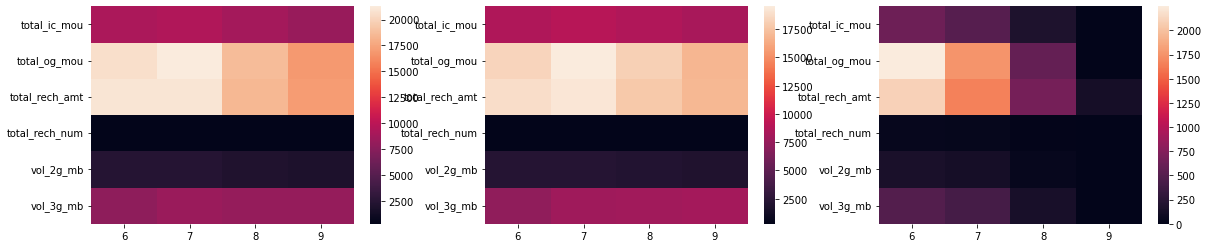

In [288]:
plt.figure(figsize=(20, 4))
plt.subplot(1,3,1); sns.heatmap(df_.astype('int').transpose())
plt.subplot(1,3,2); sns.heatmap(df_0.astype('int').transpose())
plt.subplot(1,3,3); sns.heatmap(df_1.astype('int').transpose())

In [291]:
COLS_SUMMARY = ['total_ic_mou','total_og_mou', 'total_rech_amt', 'total_rech_num', 'vol_2g_mb', 'vol_3g_mb', ]
df_ = pd.DataFrame(columns=COLS_SUMMARY)
row = 1
'''for var in COLS_SUMMARY:
    for col in [6, 7, 8, 9]:#[COLS_VOL, COLS_MONTH]:
        df_.loc[row]    = [var, 1, (df[df['churn']==0][[f'{var}_{col}']].sum().values[0]/1000).astype(int)]
        df_.loc[row+1]  = [var, 1, (df[df['churn']==0][[f'{var}_{col}']].sum().values[0]/1000).astype(int)]'''
        #df_ = ((df[cols].sum()).astype(int)) #/1000000
        #print(df_.transpose())
        #df_.loc[var, 'churn' ] = 1
        #df_.loc[var, f'{col}'] = (df[[f'{var}_{col}']].sum().values[0]/1000).astype(int)#; df_.astype(int)
        #df_.loc[var, f'{col}'] = (df[[f'{var}_{col}']].sum().values[0]/1000).astype(int)#; df_.astype(int)
        #df_0.loc[f'{col}', var] = (df[df['churn']==0][[f'{var}_{col}']].sum().values[0]/1000).astype(int)
        #df_1.loc[f'{col}', var] = (df[df['churn']==1][[f'{var}_{col}']].sum().values[0]/1000).astype(int)
        #ax = df_.plot.bar(); annotate(ax, title='Mobile internet usage volume (in TB)')
        #plt.show()
'''print(df_);print(df_0);print(df_1)'''

'print(df_);print(df_0);print(df_1)'

In [ ]:
COLS_MONTH

# Derive new features

# Pre-process data
- Impute Missing value
- Handle Outliers
- Create Dummy variables 

## Prepare data

# Model to predict customers who will churn - with PCA

# Model to identify indicators of churn - w/o PCA